<a href="https://colab.research.google.com/github/forowho/Defective-Tyre-Identification-Using-CNN-and-SVM/blob/main/Dendritic_and_non_Dendritic_Micrograph_Augmented_MobileNetV2_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import keras
import os
import glob
%matplotlib inline
import shutil
from shutil import copyfile
import random
import time
import cv2

# tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# sklearn Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Metrics Libraries
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Import dataset from google drive

In [2]:
# Download dataset
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nyb6mycvfd-1.zip

--2024-08-24 00:33:14--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nyb6mycvfd-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.64.148, 52.218.57.200, 3.5.68.194, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.64.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111332105 (106M) [application/octet-stream]
Saving to: ‘nyb6mycvfd-1.zip’

nyb6mycvfd-1.zip    100%[===================>] 106.17M  28.2MB/s    in 4.0s    

2024-08-24 00:33:18 (26.8 MB/s) - ‘nyb6mycvfd-1.zip’ saved [111332105/111332105]



In [3]:
#unzip the dataset
!unzip -q /content/nyb6mycvfd-1.zip

# Image augmentation

In [4]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
#from tensorflow.keras.utils import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range =15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         rescale=1./255,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip = True,
                         fill_mode = 'nearest',
                         data_format='channels_last',
                         brightness_range=[0.5, 1.5])

In [5]:
img_dir_Den = "/content/Dendritic" # Enter Directory of all images
data_path = os.path.join(img_dir_Den,'*g')
files = glob.glob(data_path)
data = []
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    path, dirs, files = next(os.walk("/content/Dendritic"))
    file_count = len(files) #to find number of files in folder

    for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/Augment_Dendrite',save_prefix="a",save_format='jpg'):
      i+=1
      if i>20:
        break


In [6]:
img_dir_Non_Den = "/content/Non-Dendritic" # Enter Directory of all images
data_path_N = os.path.join(img_dir_Non_Den,'*g')
files = glob.glob(data_path_N)
data_N = []
for f1 in files:
    img = cv2.imread(f1)
    data_N.append(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    path, dirs, files = next(os.walk("/content/Non-Dendritic"))
    file_count = len(files) #to find number of files in folder

    for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/Augment_Non_Dendrite',save_prefix="a",save_format='jpg'):
      i+=1
      if i>20:
        break

# Image preprocessing

In [7]:
# setting path to the main directory
main_dir = '/content/Dendrite micrograph'

In [8]:
# set path to dendritic micrograph images
dendritic_dir = '/content/Dendrite micrograph/Augment_Dendrite'
# set path to non dendritic micrograph images
non_dendritic_dir = '/content/Dendrite micrograph/Augment_Non_Dendrite'

#Print the total number of images in each directory
print("The total number of dendritic images are", len(os.listdir(dendritic_dir)))
print("The total number of non dendritic images are", len(os.listdir(non_dendritic_dir)))

The total number of dendritic images are 2148
The total number of non dendritic images are 5645


In [9]:
# Data Visualization
import matplotlib.image as mpimg

# Setting the no of rows and columns
ROWS = 4
COLS = 4

# Setting the figure size
fig = plt.gcf()
fig.set_size_inches(12, 12)

# get the directory to each image file in the trainset
non_dendritic_pic = [os.path.join(non_dendritic_dir, i) for i in os.listdir(non_dendritic_dir)[:8]]
dendritic_pic = [os.path.join(dendritic_dir, i) for i in os.listdir(dendritic_dir)[:8]]

<Figure size 1200x1200 with 0 Axes>

In [10]:
# merge dedritic and non_dendritic images
merged_list = dendritic_pic + non_dendritic_pic
print("The total number of images in the merged list are", len(merged_list))

The total number of images in the merged list are 16


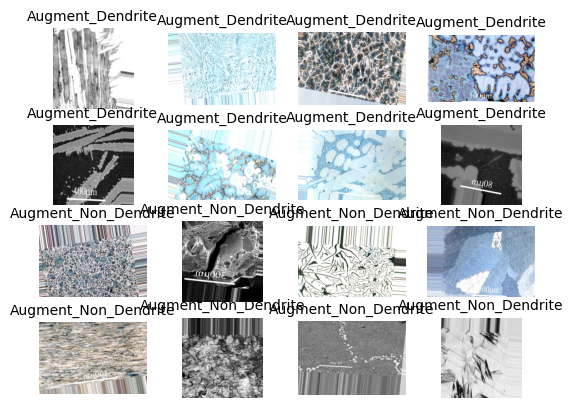

In [11]:
# Plotting the images in the merged list
for i, img_path in enumerate(merged_list):
    # getting the filename from the directory
    data = img_path.split('/', 7)[3]
    # creating a subplot of images with the no. of rows and colums with index no
    sp = plt.subplot(ROWS, COLS, i+1)
    # turn off axis
    sp.axis('Off')
    # reading the image data to an array
    img = mpimg.imread(img_path)
    # setting title of plot as the filename
    sp.set_title(data, fontsize=10)
    # displaying data as image
    plt.imshow(img, cmap='gray')

plt.show()  # display the plot

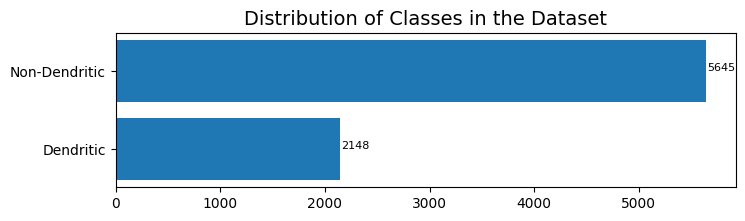

In [12]:
# Plot class distribution
plt.figure(figsize=(8,2))
x = np.arange(2)
y = [len(os.listdir(dendritic_dir)), len(os.listdir(non_dendritic_dir))]
plt.barh(x, y)
plt.yticks(x, ["Dendritic", "Non-Dendritic"], fontsize=10)
plt.text(y[0]+5, x[0], y[0], fontsize=8)
plt.text(y[1]+5, x[1], y[1], fontsize=8)
plt.title("Distribution of Classes in the Dataset", fontsize=14);

# Create the training and validation directories.
Move 80% of the data to the training directory for each class.

In [13]:
! pip install split-folders

In [14]:
import splitfolders
import os
print(os.listdir(main_dir))
splitfolders.ratio(main_dir, output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

['Augment_Non_Dendrite', 'Augment_Dendrite']


Copying files: 7793 files [00:17, 458.05 files/s]


In [15]:
output = '/content/output'
# Create "training" and "validation" directories
training_dir = os.path.join(output, "train")
validation_dir = os.path.join(output, "val")

In [16]:
tf.keras.preprocessing.image.ImageDataGenerator()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Creat data generator

In [18]:
data_gen_train = ImageDataGenerator(rescale=1/255.0)
data_gen_test = ImageDataGenerator(rescale=1/255.0)

In [19]:
train_generator = data_gen_train.flow_from_directory(training_dir,target_size=(128,128),batch_size=128,class_mode='binary')

Found 6234 images belonging to 2 classes.


In [20]:
test_generator = data_gen_test.flow_from_directory(validation_dir,target_size=(128,128),batch_size=128,class_mode='binary')

Found 1559 images belonging to 2 classes.


In [21]:
train_size = train_generator.n
val_size = test_generator.n
sample_count = train_size + val_size
print("The train_size is ",train_size)
print("The val_size is ", val_size)
print("The total sample_count is ", sample_count)

The train_size is  6234
The val_size is  1559
The total sample_count is  7793


# Model building

In [22]:
#reshaping the image
img_shape = (128,128,3)

## Loading the pretrained model (MobileNetV2)
web reference = keras.io/application
We are not importing the last layer hence include_top=False weight = imagenet because we are training the model on imagenet (base_model = conv_base #namechange)

In [23]:
conv_base = tf.keras.applications.MobileNetV2(input_shape=img_shape,include_top=False,weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
conv_base.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [25]:
#Model frezing (to enable us apply them on our own custom task)
conv_base.trainable = False

# Extracting features from MobileNetV2

In [27]:
#input layer  = [(None, 128, 128, 3)]
#target_size=(128, 128)
#last layer =  out_relu (ReLU)  = (None, 4, 4, 1280)
#shape=(sample_count, 4, 4, 1280)

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16

def extract_features(directory, sample_count):
  '''Function to extract features from images, given the directory of the images and the sample count

  Parameters:
  -----------

  directory: str, this is the directory to the different classes of images
  sample_count: int, this is the total number of samples images

  Returns:
  --------
  features (numpy array) and the corresponding label (numpy array)

  '''
  features = np.zeros(shape=(sample_count, 4, 4, 1280))  # Must be equal to the output of the convolutional base
  labels = np.zeros(shape=(sample_count))
  # Preprocess data
  generator = datagen.flow_from_directory(directory,
                                          target_size=(128, 128),
                                          batch_size = batch_size,
                                          class_mode='binary')
  # Pass data through convolutional base
  i = 0
  for inputs_batch, labels_batch in generator:
      features_batch = conv_base.predict(inputs_batch)
      features[i * batch_size: (i + 1) * batch_size] = features_batch
      labels[i * batch_size: (i + 1) * batch_size] = labels_batch
      i += 1
      if i * batch_size >= sample_count:
          break
  return features, labels

start = time.time()  # record start time
train_features, train_labels = extract_features(training_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, val_size)
end = time.time()  # record end time
print('The execution time is:', (end-start) * 10**3, 'ms')

Found 6234 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
# Reshape training data and validation
train_features = train_features.reshape(train_size, 4*4*1280)
validation_features = validation_features.reshape(val_size, 4*4*1280)

# save to csv file
np.savetxt('X_train_dendrite.csv', train_features, delimiter=',')
np.savetxt('X_val_dendrite.csv', validation_features, delimiter=',')
np.savetxt('y_train_dendrite.csv', train_labels, delimiter=',')
np.savetxt('y_val_dendrite.csv', validation_labels, delimiter=',')

In [ ]:
# clear backend session of tf
# tf.keras.backend.clear_session()

In [29]:
print(len(train_features[0]))

20480


In [30]:
print(train_labels)

[1. 1. 1. ... 1. 1. 1.]


In [31]:
# # from numpy import loadtxt
train_features = np.loadtxt('X_train_dendrite.csv', delimiter=",")
train_labels = np.loadtxt('y_train_dendrite.csv', delimiter=",")
validation_features = np.loadtxt('X_val_dendrite.csv', delimiter=",")
validation_labels = np.loadtxt('y_val_dendrite.csv', delimiter=",")

# SVM Model Training

In [32]:
# Define Evaluation Metric Functions
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


def evaluate_model(y_val, y_pred):
    """Function to evaluate model and return the metric of the model

    It returns a dictionary with the classification metrics.
    """
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    result = {"accuracy_score": accuracy,
              "precision_score": precision,
              "recall_score": recall,
              "f1_score": f1}
    return result


def plot_confusion_matrix(y_val, y_pred, label):
    '''function to plot confusion matrix

    Args
    y_val: array. The validation set of the target variable.
    y_pred: array. Model's prediction.
    label: list. A list containing all the classes in the target variable

    Returns
    It returns a plot of the confusion matrix
    '''
    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(cm, display_labels=label).plot(ax=ax, values_format='', xticks_rotation='vertical')
    plt.show()


def display_predictions(y_test, y_pred):
    """
    Display actual values and model predictions in a Pandas DataFrame for the first 10 instances.

    Args:
    y_test: true labels of the test set
    y_pred: model's prediction

    Returns:
    Pandas DataFrame containing actual values and model predictions for the first 10 instances
    """
    df_results = pd.DataFrame({"Actual": y_test[:10],
                               "Prediction": y_pred[:10]})
    return df_results


# class labels
label = ['Non-Dendritic', 'Dendritic']
RANDOM_STATE = 1

In [33]:
def train_models(X_train, X_test, y_train, y_test, model,
                 title, parameters, label=label):
    '''Function to train ML algorithms.'''

    # Train the algorithm
    print("Training the {} algorithm...".format(title))
    # Fine-tune model
    grid_search = GridSearchCV(estimator=model,
                               param_grid=parameters,
                               scoring='f1',
                               cv=5,
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # get the parameters that gave the best score
    best_parameters = grid_search.best_params_
    print("Best Parameters:", best_parameters)
    # extract the best model
    best_model = grid_search.best_estimator_

    # Evaluate model on the training set
    print("Training Result - {}".format(title))
    print(evaluate_model(y_train, best_model.predict(X_train)))
    # Evaluate model on the test set
    y_pred = best_model.predict(X_test)
    result = evaluate_model(y_test, y_pred)
    print(result)
    plot_confusion_matrix(y_test, y_pred, label)
    print(classification_report(y_test, y_pred))
    # compare the actual and predicted values
    display(display_predictions(y_test, y_pred))
    print("--------Done---------")

## SVM Model

Training the Support Vector Machine algorithm...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Training Result - Support Vector Machine
{'accuracy_score': 1.0, 'precision_score': 1.0, 'recall_score': 1.0, 'f1_score': 1.0}
{'accuracy_score': 0.8980115458627326, 'precision_score': 0.8971797337149966, 'recall_score': 0.8980115458627326, 'f1_score': 0.8975207806050356}


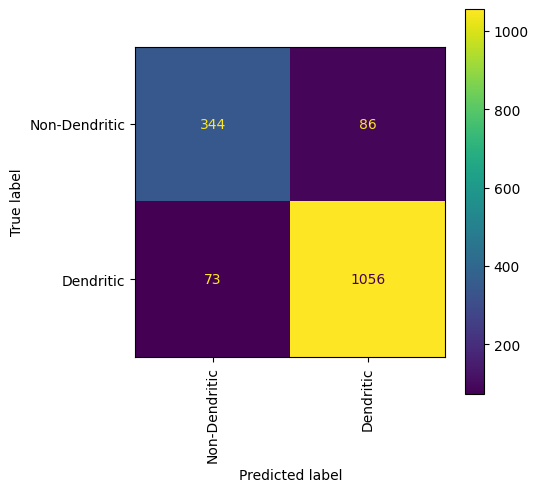

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       430
         1.0       0.92      0.94      0.93      1129

    accuracy                           0.90      1559
   macro avg       0.87      0.87      0.87      1559
weighted avg       0.90      0.90      0.90      1559



,Actual,Prediction
0,1.0,1.0
1,0.0,1.0
2,1.0,1.0
3,0.0,0.0
4,1.0,0.0
5,0.0,0.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


--------Done---------


In [34]:
# Create an SVC model
svm_model = svm.SVC()

# Define different parameter combinations to search over
parameters = {
    'C': [0.01, 0.1],  # Regularization parameter
    'kernel': ['linear']  # Kernel type
    }

# Train models
train_models(train_features,
             validation_features,
             train_labels,
             validation_labels,
             label=label,
             model=svm_model,
             parameters=parameters,
             title="Support Vector Machine")